# Importing Libraries

In [1]:
import os
import sys
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif, chi2


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Pathing & Static variable

In [2]:
CURRENT_DIR = os.getcwd()
PROJECT_DIR = os.path.dirname(CURRENT_DIR)
MODELS_PATH = os.path.join(PROJECT_DIR, 'models')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoders')
LOGS_PATH = os.path.join(MODELS_PATH, 'logs')
LOG_CURRENT = os.path.join(LOGS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
TEST_DATA_PATH = os.path.join(PROJECT_DIR, 
                              'data', 'raw', 'carInsurance_train.csv')

CATEG_PATH = os.path.join(PROJECT_DIR, 'references', 'categorical_columns.txt')
CONTI_PATH = os.path.join(PROJECT_DIR, 'references', 'continous_columns.txt')

PROJECT_NAME = '2.1-ie-Linear-SVC-model'
MODEL_NAME = 'LinearSVC-v1.0'

In [3]:
# adding system path
sys.path.insert(0, PROJECT_DIR)

In [4]:
# import internal function
from src.data import process_pipeline, encoder_pipeline, feature_selection_pipeline

# Helper Function

In [5]:
def get_content(txt_file):
    contents = []
    with open(txt_file) as file:
        for line in file:
            contents.append(line.strip())
            
    return contents

# Function to save a trained model
def save_model(model, model_name, folderPath):
    filename = os.path.join(folderPath, f"{model_name}_model.pkl")
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load a saved model
def load_model(model_name):
    filename = f"{model_name}_model.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)
    else:
        return None

# Function to evaluate a model
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)

    # DL model return float type
    if y_pred.dtype != 'int':
        y_pred = y_pred.astype('int')
        
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    return accuracy

# call backs
def callbacks(LOGS_PATH, patience):
    tensorboard_callbacks = TensorBoard(log_dir=LOGS_PATH, histogram_freq=1)
    early_callback = EarlyStopping(monitor='accuracy', patience=patience)
    return [early_callback, tensorboard_callbacks]

# Data Loading

In [6]:
df = pd.read_csv(TEST_DATA_PATH)
df = process_pipeline.process_data(df)
df.head()

c:\Users\isaac\anaconda3\envs\ds_project\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\isaac\anaconda3\envs\ds_project\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\isaac\anaconda3\envs\ds_project\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,...,sqrtBalance,cbrtBalance,negativeBalance,HasCommuncation,SinLastContactMonth,CosLastContactMonth,CallDuration,CallCategory,DaysPassed_Simplify,Outcome_Simplify
0,1,32,management,single,tertiary,0,1218,1,0,telephone,...,34.899857,10.679455,0,1,5.000000e-01,0.866025,70.0,Afternoon,0,0
1,2,32,blue-collar,married,primary,0,1156,1,0,No Communication,...,34.000000,10.495085,0,0,5.000000e-01,-0.866025,185.0,Afternoon,0,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,...,25.238859,8.604252,0,1,1.224647e-16,-1.000000,340.0,Afternoon,0,0
3,4,25,student,single,primary,0,373,1,0,cellular,...,19.313208,7.198405,0,1,5.000000e-01,-0.866025,819.0,Afternoon,0,0
4,5,30,management,married,tertiary,0,2694,0,0,cellular,...,51.903757,13.914444,0,1,1.224647e-16,-1.000000,192.0,Afternoon,0,0


In [7]:
# Get list of categorical & continous variable
categ = get_content(CATEG_PATH)
conti = get_content(CONTI_PATH)

In [8]:
# making sure there's no target
categ

['Age',
 'Job',
 'Marital',
 'Education',
 'Default',
 'DaysPassed_Simplify',
 'HHInsurance',
 'CarLoan',
 'Communication',
 'HasCommuncation',
 'LastContactDay',
 'LastContactMonth',
 'NoOfContacts',
 'PrevAttempts',
 'Outcome',
 'Outcome_Simplify',
 'CallCategory',
 'negativeBalance']

In [9]:
# label
X = df.drop(columns=['CarInsurance'])

#target
y = df['CarInsurance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
df

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,...,sqrtBalance,cbrtBalance,negativeBalance,HasCommuncation,SinLastContactMonth,CosLastContactMonth,CallDuration,CallCategory,DaysPassed_Simplify,Outcome_Simplify
0,1,32,management,single,tertiary,0,1218,1,0,telephone,...,34.899857,10.679455,0,1,5.000000e-01,0.866025,70.0,Afternoon,0,0
1,2,32,blue-collar,married,primary,0,1156,1,0,No Communication,...,34.000000,10.495085,0,0,5.000000e-01,-0.866025,185.0,Afternoon,0,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,...,25.238859,8.604252,0,1,1.224647e-16,-1.000000,340.0,Afternoon,0,0
3,4,25,student,single,primary,0,373,1,0,cellular,...,19.313208,7.198405,0,1,5.000000e-01,-0.866025,819.0,Afternoon,0,0
4,5,30,management,married,tertiary,0,2694,0,0,cellular,...,51.903757,13.914444,0,1,1.224647e-16,-1.000000,192.0,Afternoon,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,28,technician,single,tertiary,0,0,1,0,cellular,...,0.000000,0.000000,0,1,5.000000e-01,-0.866025,269.0,Afternoon,0,0
3996,3997,49,admin.,divorced,secondary,0,124,1,1,cellular,...,11.135529,4.986631,0,1,-5.000000e-01,-0.866025,125.0,Afternoon,0,0
3997,3998,27,admin.,single,secondary,0,-400,0,1,cellular,...,0.000000,-7.368063,1,1,-5.000000e-01,-0.866025,290.0,Afternoon,0,0
3998,3999,36,entrepreneur,single,tertiary,0,658,1,0,cellular,...,25.651511,8.697784,0,1,5.000000e-01,0.866025,99.0,Morning,0,0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4000.0,2000.500000,1154.844867,1.000000,1000.750000,2.000500e+03,3.000250e+03,4000.000000
Age,4000.0,41.214750,11.550194,18.000000,32.000000,3.900000e+01,4.900000e+01,95.000000
Default,4000.0,0.014500,0.119555,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000
Balance,4000.0,1532.937250,3511.452489,-3058.000000,111.000000,5.515000e+02,1.619000e+03,98417.000000
HHInsurance,4000.0,0.492750,0.500010,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000
CarLoan,4000.0,0.133000,0.339617,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000
LastContactDay,4000.0,15.721250,8.425307,1.000000,8.000000,1.600000e+01,2.200000e+01,31.000000
LastContactMonth,4000.0,6.196250,2.551639,1.000000,5.000000,6.000000e+00,8.000000e+00,12.000000
NoOfContacts,4000.0,2.607250,3.064204,1.000000,1.000000,2.000000e+00,3.000000e+00,43.000000
DaysPassed,4000.0,48.706500,106.685385,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,854.000000


# Data Preprocessing

In [12]:
# Numeric feature processing
numeric_transformer = make_pipeline(
    # scaling
    StandardScaler()
)

# Categorical feature processing
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_transformer = make_pipeline(
    ordinal_encoder,
    StandardScaler()
)

# combine pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, conti),
        ("cat", categorical_transformer, categ)
    ]
)

In [13]:
# transform to get the shape
scaler_process = make_pipeline(preprocessor)
x_train = scaler_process.fit_transform(X_train)
x_test = scaler_process.transform(X_test)

# create a input and output shape
input_shape = np.shape(x_train)[1:]
model_output = 1 # len(np.unique(y_train, axis=0)) # alternative len(df.target.unique)

In [14]:
# manual testing
model = Sequential()
model.add(Input(shape=input_shape))

# idea 1: increase neuron till accuracy hit 80 then increase the layer to 90 for 50 epochs

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(model_output, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(
    x_train, y_train,
    verbose='auto',
    epochs=50,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
)

Epoch 1/50
25/25 [==============================] - 2s 16ms/step - loss: 0.0000e+00 - accuracy: 0.6137 - val_loss: 0.0000e+00 - val_accuracy: 0.6963
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7113 - val_loss: 0.0000e+00 - val_accuracy: 0.7412
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.7459 - val_loss: 0.0000e+00 - val_accuracy: 0.7588
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.7591 - val_loss: 0.0000e+00 - val_accuracy: 0.7812
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7878 - val_loss: 0.0000e+00 - val_accuracy: 0.7900
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.7981 - val_loss: 0.0000e+00 - val_accuracy: 0.8062
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8066 - val_los

In [15]:
evaluate_model(model, 'manual_keras', x_test, y_test)

25/25 [==============================] - 0s 2ms/step
manual_keras - Test Accuracy: 0.8213


0.82125

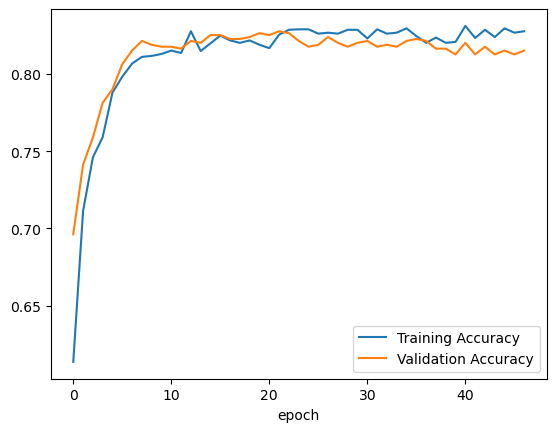

In [16]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [17]:
# def create_model(input_shape, model_output):
#     model = Sequential()
#     # input layer
#     model.add(Input(shape=input_shape))

    
#     # layer 1
#     model.add(Dense(256, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     # layer 2
#     model.add(Dense(512, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     # output
#     model.add(Dense(model_output, activation='sigmoid'))
#     model.compile(optimizer='adam', 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy']
#                  )
#     return model

In [18]:
# callbacks
early_callback, tensorboard_callbacks = callbacks(LOGS_PATH, patience=100)

In [19]:
clf = KerasClassifier(
    build_fn=create_model,
    callbacks=[early_callback, tensorboard_callbacks],
    verbose=0
)

NameError: name 'create_model' is not defined

In [ ]:
clf.get_params

In [ ]:
pipeline = make_pipeline(
    preprocessor,
    clf
)

In [ ]:
# model training
pipeline.fit(X_train, y_train)

In [ ]:
evaluate_model(pipeline, 'keras', X_test, y_test)

In [ ]:
# try:
#     scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
#     print(f"Sequential DL: Accuracy - {scores.mean():.4f} (± {scores.std():.4f})")
    
# except Exception as e:
#     print(f"Sequential DL: Fit failed with error: {e}")